# Нормальность распределения и тесты

## В данном ноутбуке я рассмотрю применимость разных функций для нормального распределения и варианты тестов ##

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest

****
**Рассмотрим пример задачи с это одной из ключевых метрик (коэффициент NPL, Non-performing loans)** \
Микрокредитные организации имеют значение доли проблемных кредитов (NPL) в кредитном портфеле в среднем на уровне 7,45% по сектору. Стандартное отклонение равно 1.36%. Считаем, что распределение является нормальным. 

Чему равна вероятность того, что случайно выбранная микрокредитная организация будет иметь долю NPL в портфеле, не превышающую 8,99%?

In [63]:
# Создадим норм. распределение с μ=0.0745 σ=0.0136
mu = 0.0745
sigma = 0.0136
x = 0.0899
dist = stats.norm(mu, sigma)

Для расчета используем **кумулятивную функцию распределения (cumulative distribution function, CDF)** от значения х, которая определяет долю наблюдений выборки, значения которых меньше или равно х, иначе говоря вероятность попадания случайной величины в интервал от −∞ до х

In [59]:
# Расчитаем вероятность CDF(x)
probability = dist.cdf(x)

print(f'Вероятность того, что NPL не превышает 8.99%: {round(probability, 5)}')

Вероятность того, что NPL не превышает 8.99%: 0.87126


Чтобы убедиться, что расчёт через `scipy.stats.norm(mu, sigma).cdf(x)` корректен, сделаем проверку через **z-score**.

In [83]:
# z-score вычисляется как (x − μ) / σ и показывает положение конкретного значения относительно среднего
z = (x - mu) / sigma

In [84]:
stats.norm.cdf(z) == probability

True

Ответ: Полученное значение вероятности показывает, что около 87% микрокредитных организаций в секторе имеют долю проблемных кредитов не выше 8.99%, при предположении нормального распределения показателя NPL.

****

**Теперь нарисуем графики функций CDF(x), PDF(x), SF(x), PPF(x), ISF(x)**

In [64]:
x_vals = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000) # Создадим ось X

In [71]:
p_vals = np.linspace(0.001, 0.999, 1000)

(0.0, 1.0, 0.0, 1.0)

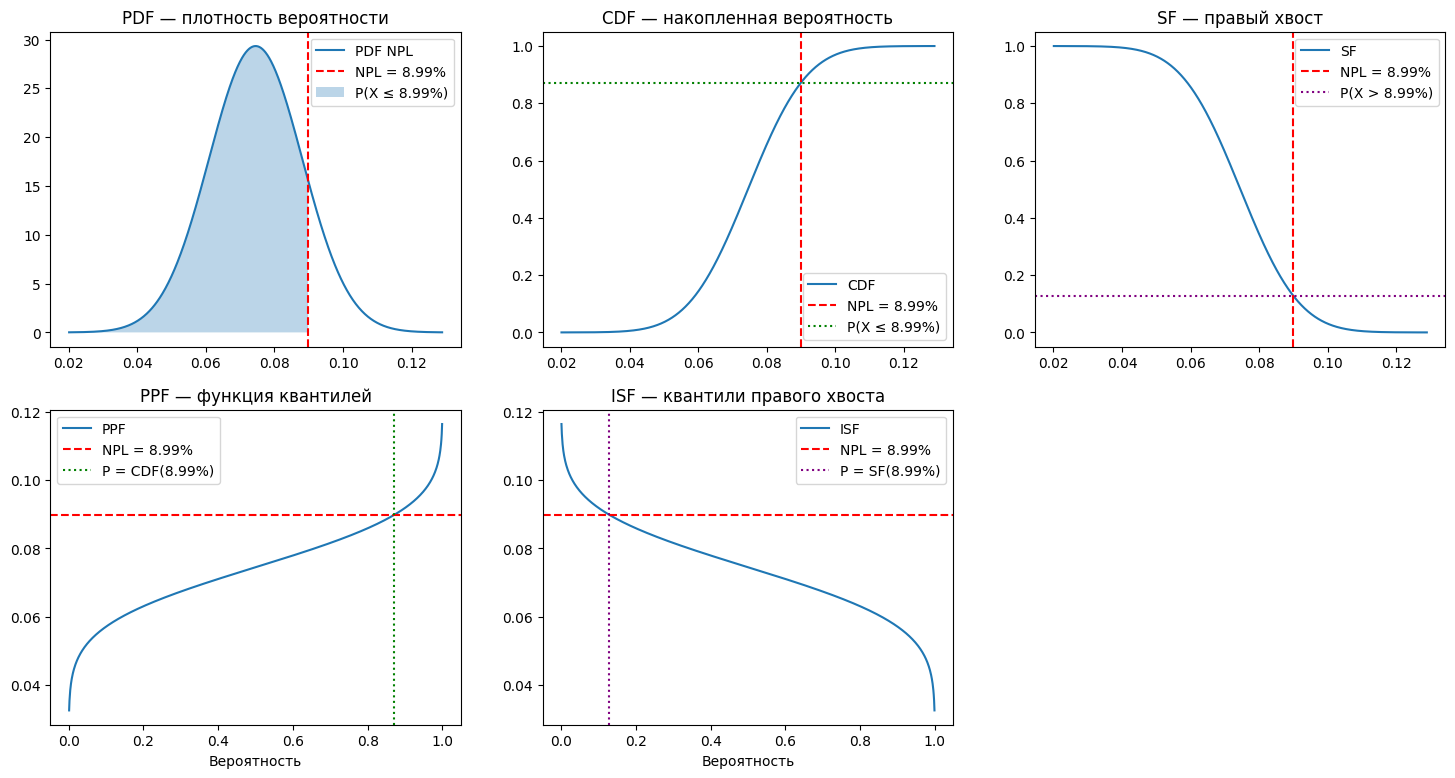

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

y_pdf = dist.pdf(x_vals)

axes[0].plot(x_vals, y_pdf, label='PDF NPL')
axes[0].axvline(x, color='red', linestyle='--', label='NPL = 8.99%')
axes[0].fill_between(
    x_vals,
    y_pdf,
    where=(x_vals <= x),
    alpha=0.3,
    label='P(X ≤ 8.99%)'
)
axes[0].set_title('PDF — плотность вероятности')
axes[0].legend()

y_cdf = dist.cdf(x_vals)

axes[1].plot(x_vals, y_cdf, label='CDF')
axes[1].axvline(x, color='red', linestyle='--', label='NPL = 8.99%')
axes[1].axhline(dist.cdf(x), color='green', linestyle=':', label='P(X ≤ 8.99%)')
axes[1].set_title('CDF — накопленная вероятность')
axes[1].legend()

y_sf = dist.sf(x_vals)

axes[2].plot(x_vals, y_sf, label='SF')
axes[2].axvline(x, color='red', linestyle='--', label='NPL = 8.99%')
axes[2].axhline(dist.sf(x), color='purple', linestyle=':', label='P(X > 8.99%)')
axes[2].set_title('SF — правый хвост')
axes[2].legend()

axes[3].plot(p_vals, dist.ppf(p_vals), label='PPF')
axes[3].axhline(x, color='red', linestyle='--', label='NPL = 8.99%')
axes[3].axvline(dist.cdf(x), color='green', linestyle=':', label='P = CDF(8.99%)')
axes[3].set_title('PPF — функция квантилей')
axes[3].set_xlabel('Вероятность')
axes[3].legend()

axes[4].plot(p_vals, dist.isf(p_vals), label='ISF')
axes[4].axhline(x, color='red', linestyle='--', label='NPL = 8.99%')
axes[4].axvline(dist.sf(x), color='purple', linestyle=':', label='P = SF(8.99%)')
axes[4].set_title('ISF — квантили правого хвоста')
axes[4].set_xlabel('Вероятность')
axes[4].legend()

axes[5].axis('off')


Для наглядности визуализированы основные функции нормального распределения, что даёт целостное представление о распределении случайной величины. \
PDF иллюстрирует форму распределения, CDF и SF — вероятности превышения и непревышения порога, а PPF и ISF позволяют определить пороговые значения
по заданному уровню вероятности.

****
### Тесты на проверку нормальности распределения
Тесты на нормальность сравнивают проверяемую выборку с теоретическим распределением (в нашем случае с нормальным) с такими же значениями среднего и стандартного отклонения. Нулевая гипотеза заключается в том, что выборка имеет нормальное распределение. В случае наличия оснований (например, при p-value < 0.05) считать, что полученные в тесте различия являются статистически значимыми, мы можем отвергнуть нулевую гипотезу о нормальности распределения. \
<br>
_* Рассмотрим тесты Колмогорова-Смирнова с поправкой Лиллиефорса (для больших выборок с симметричным распределением) и Шапиро-Уилка (для небольших выборок с возможной асимметрией)_

In [94]:
# Загрузим набор данных из 1254 значений ежедневных изменения индекса S&P 500
df = pd.read_csv('SP_500_returns.csv', delimiter=';')
df.head(3)

,Date,Return_SP_500
0,02.12.2014,0.006384
1,03.12.2014,0.003765
2,04.12.2014,-0.001162


In [95]:
returns = df['Return_SP_500'].dropna()

In [96]:
mu, sigma = returns.mean(), returns.std(ddof=1)

ks_stat, ks_p = stats.kstest(returns, 'norm', args=(mu, sigma))

ks_stat, ks_p


(0.10377722845895654, 3.2677807516225686e-12)

In [97]:
shapiro_stat, shapiro_p = stats.shapiro(returns)

shapiro_stat, shapiro_p


(0.9419242939802135, 9.18084680114666e-22)